In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
%matplotlib inline

In [3]:
# dataset을 불러옵니다.

cg = pd.read_csv('medical_checkup_mean.csv')

cg_df = pd.DataFrame(cg)

del cg_df['Unnamed: 0']

cg_df = cg_df.sort_values(by=['person_id','test_age'])

#### 여러 회차에 걸친 위염환자들의 건강검진 데이터

In [4]:
cg_df

,person_id,gender,age,date,bmi,smoking status,smoking_duration,amount of smoking,alcohol_habit,income,family_cancer,test_age,cancer
0,10224187,0,75,2009,17.360000,3.0,5,2,1.0,2.0,1,64,0
1,10224187,0,75,2009,17.360000,3.0,1,2,1.0,2.0,1,64,0
2,10410714,0,70,2009,28.010000,3.0,5,4,1.0,7.0,1,59,1
3,10410714,0,70,2013,25.510000,3.0,4,1,1.0,7.0,1,63,1
4,10485977,0,53,2012,27.460000,3.0,4,3,4.0,10.0,1,45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,53078031,0,80,2009,23.457522,3.0,5,3,1.0,8.0,1,69,1
1045,53346919,0,76,2005,20.830000,3.0,5,3,1.0,5.0,1,61,0
1046,53369201,0,74,2002,23.457522,3.0,4,1,1.0,7.0,1,56,1
1047,53369201,0,74,2004,23.457522,3.0,5,1,1.0,8.0,1,58,1


In [9]:
cg_df.columns

Index(['person_id', 'gender', 'age', 'date', 'bmi', 'smoking status',
       'smoking_duration', 'amount of smoking', 'alcohol_habit', 'income',
       'family_cancer', 'test_age', 'cancer'],
      dtype='object')

### y_label 생성 
##### 한사람 당 여러 회차의 기록이 있어 person_id와 cancer 여부가 중복 되므로 
##### 이를 고려하여 중복을 제거하여 레이블을 생성

In [21]:
# Y_label

cg_y = cg_df.loc[:,['person_id','cancer']]
cg_y = cg_y.drop_duplicates(['person_id'])

y_label = cg_y['cancer']

In [22]:
cg_y

,person_id,cancer
0,10224187,0
2,10410714,1
4,10485977,0
5,10486529,0
8,10879002,0
...,...,...
1039,52430195,0
1042,52560487,0
1044,53078031,1
1045,53346919,0


In [23]:
# y_label
Counter(y_label)

Counter({0: 250, 1: 250})

### 전처리 단계
##### 수치형 변수에 대해 범주형 변수와 비교할 때 값의 차이가 크므로
##### 이를 보완하기 위해 정규형으로 변환하는 전처리를 실시

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [11]:
def pipeline(df):

    num_pipeline=Pipeline([
        ("select_numeric",DataFrameSelector(['bmi','age','test_age'])),
        ("scaler", StandardScaler())])

    cat_pipeline = Pipeline([
        ("select_cat",DataFrameSelector(['gender','smoking status','smoking_duration','amount of smoking','alcohol_habit','income','family_cancer']))])
    
    preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)])
    
    X=preprocess_pipeline.fit_transform(df)
    
    return X

### 2차원 데이터를 3차원으로 변환하는 과정
##### 환자의 개인별  n년치 건강검진 데이터이므로,
##### 환자별로 학습이 이뤄지기 위해서 기존 표 형식과 같은 2차원 데이터에서
##### 시간의 순서를 고려한 3차원 데이터로의 변환이 필요함.

In [15]:
def make_metrics(df, X):
    
    person_id = df['person_id']
    ids = person_id.iloc[0]
    new_mat = []
    person=[]

    for i in range(len(df)):  
        if ids == person_id.iloc[i]:
            person.append(X[i])
            ids = person_id.iloc[i]
        else:
            new_mat.append(person)
            person=[]
            person.append(X[i])
            ids = person_id.iloc[i]
    new_mat.append(person)
    
    return new_mat

### Padding & Convert to tensor
##### 올바른 RNN 학습을 위해 가변길이의 데이터를 같은 길이로 늘려주는 작업(padding)과
##### array 형태의 데이터 형식을 RNN 학습에 용이한 Tensor로 변환하는 과정

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def convert(new_mat):
    
    max_len=0
    for data in new_mat:
        if len(data)>max_len:
            max_len = len(data)

    X_data = pad_sequences(new_mat, padding='post',value=-1, maxlen=max_len)
    X_data = tf.convert_to_tensor(X_data, dtype=tf.float32)
    
    return X_data

In [18]:
# Pretreatment
X = pipeline(cg_df)

# convert to 3D Array
new_mat = make_metrics(cg_df, X)

# Padding & Conver to tensor
X_data = convert(new_mat)

### Train / Test data

In [19]:
from tensorflow.keras.utils import to_categorical

In [24]:
train_x = X_data[:int(0.7*len(X_data))]
test_x = X_data[int(0.7*len(X_data)):]

train_y = y_label[:int(0.7*len(X_data))]
test_y = y_label[int(0.7*len(X_data)):]

train_y1 = to_categorical(train_y)
test_y1 = to_categorical(test_y)

In [27]:
print('Train data : %d' %len(train_x))
print('Test data : %d' %len(test_x))

print('Train data label => %s' %Counter(train_y))
print('Test data label => %s' %Counter(test_y))

Train data : 350
Test data : 150
Train data label => Counter({0: 176, 1: 174})
Test data label => Counter({1: 76, 0: 74})


### RNN Model

In [50]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

In [30]:
model = Sequential()
model.add(SimpleRNN(16, input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(SimpleRNN(16,  return_sequences=True))
model.add(SimpleRNN(16, return_sequences=False))
model.add(Dense(2, activation='softmax'))

In [51]:
model = Sequential()
model.add(LSTM(16, input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(LSTM(16,  return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(2, activation='softmax'))

In [52]:
# RNN Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 16)            1728      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 5,986
Trainable params: 5,986
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])

model.fit(train_x,train_y1,epochs=100,batch_size=64,validation_split=0.2)

Train on 280 samples, validate on 70 samples
Epoch 1/100
280/280 [==============================] - 5s 18ms/sample - loss: 0.7006 - accuracy: 0.5036 - val_loss: 0.6825 - val_accuracy: 0.6714
Epoch 2/100
280/280 [==============================] - 0s 253us/sample - loss: 0.6870 - accuracy: 0.5571 - val_loss: 0.6793 - val_accuracy: 0.5000
Epoch 3/100
280/280 [==============================] - 0s 260us/sample - loss: 0.6813 - accuracy: 0.5750 - val_loss: 0.6735 - val_accuracy: 0.6571
Epoch 4/100
280/280 [==============================] - 0s 271us/sample - loss: 0.6735 - accuracy: 0.6357 - val_loss: 0.6758 - val_accuracy: 0.5286
Epoch 5/100
280/280 [==============================] - 0s 271us/sample - loss: 0.6631 - accuracy: 0.6107 - val_loss: 0.6558 - val_accuracy: 0.6857
Epoch 6/100
280/280 [==============================] - 0s 260us/sample - loss: 0.6549 - accuracy: 0.6036 - val_loss: 0.6569 - val_accuracy: 0.6000
Epoch 7/100
280/280 [==============================] - 0s 267us/sample - l

Epoch 56/100
280/280 [==============================] - 0s 296us/sample - loss: 0.5405 - accuracy: 0.6964 - val_loss: 0.6944 - val_accuracy: 0.6286
Epoch 57/100
280/280 [==============================] - 0s 306us/sample - loss: 0.5648 - accuracy: 0.6857 - val_loss: 0.6313 - val_accuracy: 0.6429
Epoch 58/100
280/280 [==============================] - 0s 321us/sample - loss: 0.5372 - accuracy: 0.7143 - val_loss: 0.6384 - val_accuracy: 0.6571
Epoch 59/100
280/280 [==============================] - 0s 370us/sample - loss: 0.5346 - accuracy: 0.7214 - val_loss: 0.6521 - val_accuracy: 0.6429
Epoch 60/100
280/280 [==============================] - 0s 306us/sample - loss: 0.5348 - accuracy: 0.7107 - val_loss: 0.6541 - val_accuracy: 0.6429
Epoch 61/100
280/280 [==============================] - 0s 296us/sample - loss: 0.5386 - accuracy: 0.7000 - val_loss: 0.6343 - val_accuracy: 0.6143
Epoch 62/100
280/280 [==============================] - 0s 271us/sample - loss: 0.5470 - accuracy: 0.6857 - val_

### Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix,classification_report

In [55]:
test_pred = model.predict_classes(test_x)

test_pred = [a for a in test_pred]

In [56]:
#test_pred

In [57]:
print('predict label => %s' %Counter(test_pred))
print('real label => %s' %Counter(test_y))

predict label => Counter({0: 79, 1: 71})
real label => Counter({1: 76, 0: 74})


In [58]:
print(confusion_matrix(test_y,test_pred,labels=[1,0]))

[[47 29]
 [24 50]]


In [59]:
print(classification_report(test_y,test_pred))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65        74
           1       0.66      0.62      0.64        76

    accuracy                           0.65       150
   macro avg       0.65      0.65      0.65       150
weighted avg       0.65      0.65      0.65       150



### ROC Curve & AUC

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics

0.7220839260312945


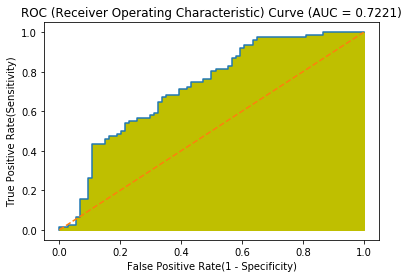

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict_proba(test_x)[:,1]) #곡선 그리기

plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='y')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

plt.title('ROC (Receiver Operating Characteristic) Curve (AUC = {})'.format(round(score,4)))
plt.show()